<a href="https://colab.research.google.com/github/javierbaldrich/5511/blob/main/cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Histopathologic Cancer Detection
In this exercise I will train a deep learning model with a convolutional neural network and a neural network classifier using the Keras library.

Due to the size of the dataset (7GB+), I will do this in my local PC since Google Drive has size limitations. The initial EDA, however I will write in a Google Colaboratory notebook sicne it is neater to look at.

The training dataset consists of 220,025 images of taken from microscopes, which are labeled 1 (indicating the presence of cancer in the innter 32x32 square) or 0 (indicating the absence of it). The images are 96x96 pixels.

The test dataset, on the other hand, cosists of 57,458 unlabeled images of the same size.

The objective is to train a model to detect the presence of cancer in this 32x32 area.

#Data Import

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os
from skimage import io
from google.colab import drive 

drive.mount('/content/gdrive')
train_dir = '/content/gdrive/MyDrive/5511/train/'
train_df = pd.read_csv('/content/gdrive/MyDrive/5511/train_labels.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Incidence of cancer in training dataset

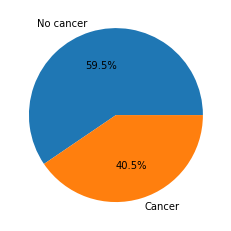

In [ ]:
label_counts = train_df['label'].value_counts()*100/len(train_df)
labels = ['No cancer', 'Cancer']
fig1, ax1 = plt.subplots()
ax1.pie(label_counts, labels=labels, autopct='%1.1f%%')
plt.show()

#Some of the training images

As you can see the images are larger than the area in which we will look for the illness. Here is an example of 12 images.

We can see that, even though the Kaggle competition states that there are no duplicates, the third image from the left in row 1 and the fourth image form the left in row 2 are actually the same image although slightly shifted.

However, since the inner 32x32 square changes from picture to pictue, I will not find and replace images duplicates like these.


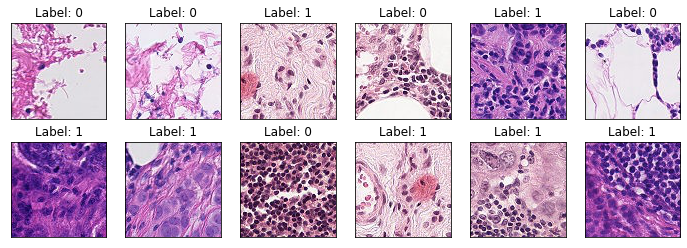

In [ ]:

fig = plt.figure(figsize=(12, 4))
for root, dirs, files in os.walk(train_dir):
   for ix, file_name in enumerate(files):
      ax = fig.add_subplot(2, 12//2, ix+1, xticks=[], yticks=[])
      img = io.imread(os.path.join(root, file_name))
      plt.imshow(img)
      lab = train_df.loc[train_df['id'] == file_name.split('.')[0], 'label'].values[0]
      ax.set_title('Label: %s'%lab)

# Model training: things that did not work


1.   Varying input sizes: I wrote the model so that the image input size would be a hyperparameter and then iterated training models with images of 32x32, 34x34, 3636 and 38x38 pixels (alwayes centered in the middle of the image). The idea behind this was to gather additonal information from the surrounding pixels that could help me understand if there was any cancer present in the middle. This however did not work as intended. Validation accuracy decreased as input size increased.


2.   Color processing: I tried to apply some random color alteration to the train images. First I got the standard deviation for each channel and then I applied that deviation (multiplied by a Normal (0 0.0025) distribution) to the images. This was by far the worst thing I tried. Even this small alteration decreased validation accuracy by 10-15%. The reason for this, I think, is that all images are already taken in a very controlled environment, so even the smallest color processing will not be useful and throw the model off track.

```
def color_processing(pos_pr_imgs, input_size):
    std_dev = np.std(pos_pr_imgs, (0, 1, 2))
    processed_imgs = np.ndarray(shape=(len(pos_pr_imgs), input_size, input_size, 3), dtype=float)
    for ix, image in enumerate(pos_pr_imgs):
        image = image + std_dev * np.random.normal(0, 0.0025)
        image = np.where(image > 1, 1, image)
        image = np.where(image < 0, 0, image)
        processed_imgs[ix] = image
    return processed_imgs
```






# Model training: things that worked

1.   I dropped the images listed below, since they are completely black or white

```
faulty_ids = [
    '9369c7278ec8bcc6c880d99194de09fc2bd4efbe', 
    'f6f1d771d14f7129a6c3ac2c220d90992c30c10b', 
    '9071b424ec2e84deeb59b54d2450a6d0172cf701', 
    'c448cd6574108cf14514ad5bc27c0b2c97fc1a83', 
    '54df3640d17119486e5c5f98019d2a92736feabc', 
    '5f30d325d895d873d3e72a82ffc0101c45cba4a8', 
    '5a268c0241b8510465cb002c4452d63fec71028a'
]
```

2.   I performed some basic positional processing to train images (rotations of 90° increments, x-axis and y-axis flipping):

```
def positional_processing(ids, input_size, dir, is_train):
    processed_imgs = np.ndarray(shape=(len(ids), input_size, input_size, 3), dtype=float)/255
    for ix, id in enumerate(ids):
        image = io.imread(os.path.join(dir, id + '.tif'))
        if is_train:
            # Rotation
            image = transform.rotate(image, np.random.choice([0, 90, 180, 270]), preserve_range=True).astype(np.uint8)
            # Flip
            if(np.random.choice([True, False])):
                image = image[::-1, :]
            if(np.random.choice([True, False])):
                image = image[:, ::-1]
        # Crop
        new_img = image[int((96-input_size)/2):int((96-input_size)/2)+input_size, int((96-input_size)/2):int((96-input_size)/2)+input_size, :]
        processed_imgs[ix] = new_img
    return processed_imgs
```


3.   Then I use the Keras library to define a model with a convolutional neural netwrok feature extractor and a neural netwrok classifier:

```
model = keras.Sequential()
model.add(Conv2D(64, (3, 3), activation="relu", input_shape = (input_size, input_size, 3)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.75))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=64, batch_size=4096)
model.save('cancer_model')
```

4. The number of epochs was determined by looking at the loss function of a 20% validation split of the training dataset across 128 epochs. 

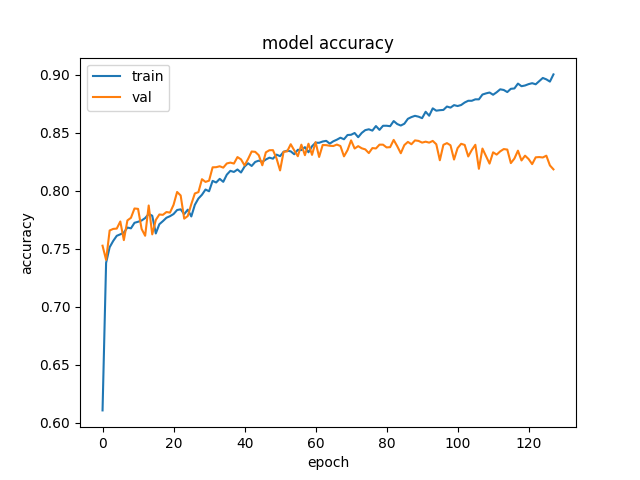

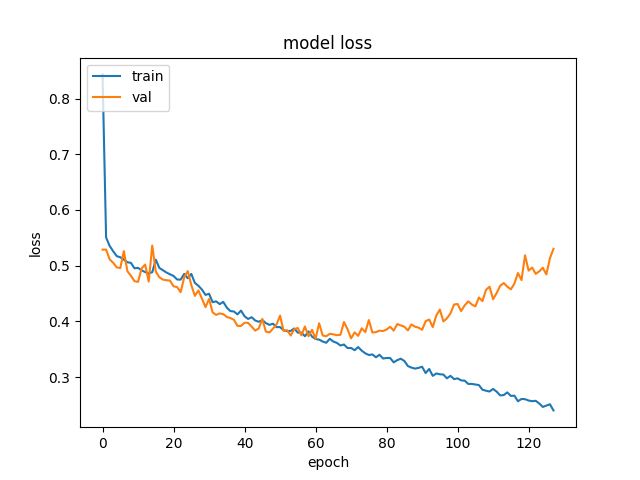


# Conclusions

Even after ~40 submissions trying different approaches, my models did not score as well as the best models in Kaggle.

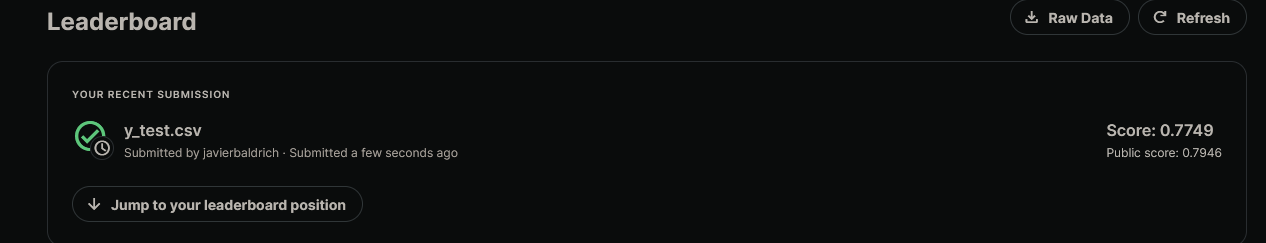

Regardless, here are some interesting insights I am going away with.


1. Models don't have to be perfect. Most images are 'evident' for the model, it does need improvement in classifying the ones that are trickier to detect. Even if the model was misclassifying only 5% of images (as the top models in Kaggle do), it would be of great help in practical application, since it could do most of the detection and leave only the hardest questions to real oncologists.

2. Don't trust the input data. Even though the Kaggle dataset had been curated in advance, there were multiple completely white/black images that hindered model training.

3. A simple model is fine when images are this small (especially after trimming the inner 32x32 center). I did waste a lot of time with over-the-top models that tested the limits of my new PC.

4. I needed a new PC.